In [1]:
import numpy as np
from numpy.random import random_integers
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from scipy.stats import pointbiserialr, spearmanr
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
path = '~/Documents/DSE/Data/HW3_220/Titanic/'
df = pd.read_csv(path+'train.csv')

Looking at our dataframe

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


####Process Data

People with stronger titles tend to have more help on board. Hence, we will categorize passengers based on titles.

In [4]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    } 

df['Title'] = df['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Now let's check for data types and missing values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


We can see that Age and Embarked has missing data. 

Simply dropping the Age NaNs would mean throwing away too much data. 

We add in the median age based on the Title, Pclass and Sex of each passenger.

In [6]:
mask_Age = df.Age.notnull()
Age_Sex_Title_Pclass = df.loc[mask_Age, ["Age", "Title", "Sex", "Pclass"]]
Filler_Ages = Age_Sex_Title_Pclass.groupby(by = ["Title", "Pclass", "Sex"]).median()
Filler_Ages = Filler_Ages.Age.unstack(level = -1).unstack(level = -1)

mask_Age = df.Age.isnull()
Age_Sex_Title_Pclass_missing = df.loc[mask_Age, ["Title", "Sex", "Pclass"]]

def Age_filler(row):
    if row.Sex == "female":
        age = Filler_Ages.female.loc[row["Title"], row["Pclass"]]
        return age
    
    elif row.Sex == "male":
        age = Filler_Ages.male.loc[row["Title"], row["Pclass"]]
        return age
    
Age_Sex_Title_Pclass_missing["Age"]  = Age_Sex_Title_Pclass_missing.apply(Age_filler, axis = 1)   

df["Age"] = pd.concat([Age_Sex_Title_Pclass["Age"], Age_Sex_Title_Pclass_missing["Age"]])    

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Next we fill in the missing Fare.

In [7]:
df['Fare']=df['Fare'].fillna(value=df.Fare.mean())
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


We do not need Cabin and Ticket and hence can be dropped from our DataFrame.

We also can combine SibSp and Parch to FamilySize.

In [8]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df = df.drop(['Ticket', 'Cabin'], axis=1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,0


Now we deal with categorical data using dummy variables.

In [9]:
dummies_Sex=pd.get_dummies(df['Sex'],prefix='Sex')
dummies_Embarked = pd.get_dummies(df['Embarked'], prefix= 'Embarked') 
dummies_Pclass = pd.get_dummies(df['Pclass'], prefix= 'Pclass')
dummies_Title = pd.get_dummies(df['Title'], prefix= 'Title')
df = pd.concat([df, dummies_Sex, dummies_Embarked, dummies_Pclass, dummies_Title], axis=1)
df = df.drop(['Sex','Embarked','Pclass','Title','Name'], axis=1)

df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,...,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,0,22.0,1,0,7.2500,1,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,26.0,0,0,7.9250,0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0,35.0,0,0,8.0500,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Finally, we set our PassengerId as our index.

In [10]:
df = df.set_index(['PassengerId'])
df.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,26.0,0,0,7.9250,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0,35.0,0,0,8.0500,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


####Feature Selection

For feature selection, we will look at the correlation of each feature against Survived.

Based on our data types, we will use the following aglorithms:

- Spearman-Rank correlation for nominal vs nominal data

- Point-Biserial correlation for nominal vs continuous data

In [11]:
columns = df.columns.values

param=[]
correlation=[]
abs_corr=[]

for c in columns:
    #Check if binary or continuous
    if len(df[c].unique())<=2:
        corr = spearmanr(df['Survived'],df[c])[0]
    else:
        corr = pointbiserialr(df['Survived'],df[c])[0]
    param.append(c)
    correlation.append(corr)
    abs_corr.append(abs(corr))

#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param, 'abs_corr':abs_corr})

#Sort by absolute correlation
param_df=param_df.sort_values(by=['abs_corr'], ascending=False)

#Set parameter name as index
param_df=param_df.set_index('parameter')

param_df

,abs_corr,correlation
parameter,,
Survived,1.000000,1.000000
Title_Mr,0.549199,-0.549199
Sex_female,0.543351,0.543351
Sex_male,0.543351,-0.543351
Title_Mrs,0.344935,0.344935
Title_Miss,0.332795,0.332795
Pclass_3,0.322308,-0.322308
Pclass_1,0.285904,0.285904
Fare,0.257307,0.257307


Now that we have our correlation, we can use the Decision Tree classifier to see the score agaisnt feature space.

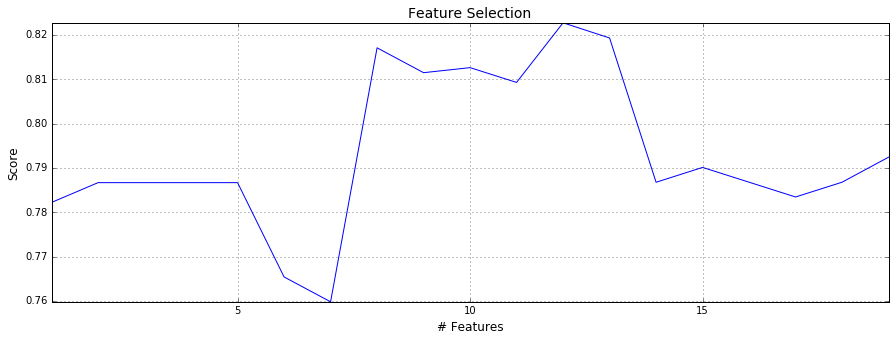

In [12]:
scoresCV = []
scores = []

for i in range(1,len(param_df)):
    new_df=df[param_df.index[0:i+1].values]
    X = new_df.ix[:,1::]
    y = new_df.ix[:,0]
    clf = DecisionTreeClassifier()
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
    
plt.figure(figsize=(15,5))
plt.plot(range(1,len(scores)+1),scores)
plt.axis("tight")
plt.title('Feature Selection', fontsize=14)
plt.xlabel('# Features', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid();

Based on the plot, a feature space of 13 dimensions provides the most reliable result.

In [13]:
best_features=param_df.index[1:13+1].values
# best_features=param_df.index.values[1::]
print 'Best features:\t',best_features

Best features:	['Title_Mr' 'Sex_female' 'Sex_male' 'Title_Mrs' 'Title_Miss' 'Pclass_3'
 'Pclass_1' 'Fare' 'Embarked_C' 'Embarked_S' 'Pclass_2' 'Title_Master'
 'Parch']


####Decision Tree

In [18]:
X = df[best_features]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

Analyzing Features

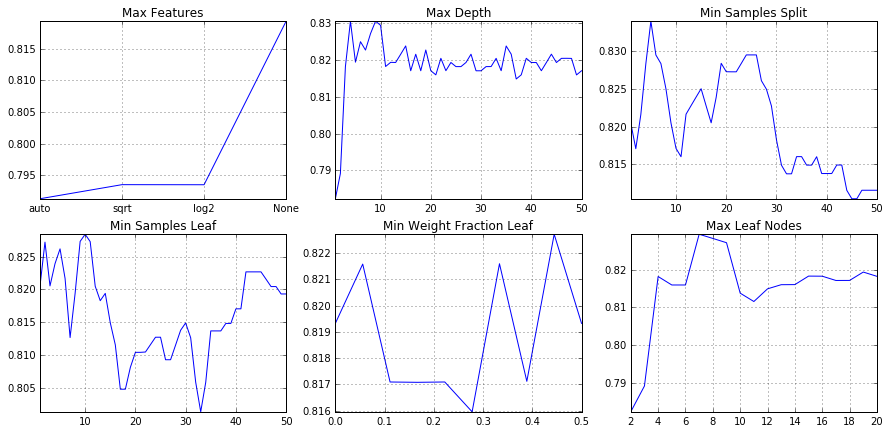

In [62]:
plt.figure(figsize=(15,7))

#Max Features
plt.subplot(2,3,1)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(scores)
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(max_feature_param)), max_feature_param)
plt.grid();

#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores)
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(2,3,3)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores)
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Samples Leaf
plt.subplot(2,3,4)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores)
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Leaf')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores)
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(2,3,6)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores)
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();